## 6. Nonlinear ensemble filtering for the Lorenz-63 problem

In this notebook, we are interested in the sequential inference 



References: 


[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `AdaptiveTransportMap`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

We will go through all of these here.

In [1]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using OrdinaryDiffEq

Load some packages to make nice figures

In [2]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [3]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [4]:
Δtdyn = 0.05
Δtobs = 0.1

0.1

Define the additive inflation for the dynamical and observation models

Define the time span of interest

In [5]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, tf/Δtobs)

1000

Define the properties of the initial condition

In [6]:
m0 = zeros(Nx)
C0 = Matrix(1.0*I, Nx, Nx);

We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(t,x) = x$.

In [7]:
h(t,x) = x
F = StateSpace(lorenz63!, h)

StateSpace(AdaptiveTransportMap.lorenz63!, h)

In [8]:
σx = 1e-2
σy = 2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0])

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\boldsymbol{x}^i$ o generate i.i.d. samples from the system’s invariant (long-time) distribution, we sampleninitialconditions from a multivariate standard Gaussian distribution.  For each sample, we run the ODEin equation(SM.25)forT=  40,000steps using the Runge-Kutta method with a time-step of∆t= 0.01. The samples of the state at the final time are then i.i.d. samples from the push-forwarddistribution of the standard Gaussian through the nonlinear forward dynamics forTsteps

In [19]:
# Define the distribution for initial condition
# Number of runs
Ne = 300
πx0 = MvNormal(zeros(Nx), ones(Nx))
# Zero vector of the size of the state
x0 = rand(πx0)

# Time stepp
tspan = (0.0, 500.0)
prob = ODEProblem(lorenz63!,x0, tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 500.0)
u0: [-0.8487497941669317, -0.12596622342763736, 0.24458076438031867]

Create cache to store the different final solutions

In [20]:
X = zeros(Ny + Nx, Ne);

Solve Lorenz-96 model for the different initial conditions and store the solutions as the columns of `X`, and compute the associated observation vector.

In [21]:
@inbounds for i=1:Ne
    prob = remake(prob; u0 = rand(πx0))
    sol = solve(prob, Tsit5(), dt = 0.01, adaptive = false, dense = false, saveat = tspan[end], save_start = false)
    # Store the state
    X[Ny+1:Ny+Nx,i] .= deepcopy(sol.u[1])
end
# Apply the process noise
ϵx(X, Ny+1, Ny+Nx)
# Generate the observations
observe(h, tf, X, Ny, Nx)
# Apply the observation noise
ϵy(X, 1, Ny)

In [41]:
m = 30
S = HermiteMap(m, X; diag = true)

HermiteMap(30, 6, LinearTransform(6, [0.6713450149638673, 1.0994859819928526, 24.32824699886164, -0.3280591106622135, 0.16473498946032858, 23.34191641815483], [7.761566816930852 0.0 … 0.0 0.0; 0.0 9.309146991767813 … 0.0 0.0; … ; 0.0 0.0 … 9.33587152881682 0.0; 0.0 0.0 … 0.0 8.186962626219328], true), MapComponent[Map component of dimension 1 with Nψ 1 active features
, Map component of dimension 2 with Nψ 1 active features
, Map component of dimension 3 with Nψ 1 active features
, Map component of dimension 4 with Nψ 1 active features
, Map component of dimension 5 with Nψ 1 active features
, Map component of dimension 6 with Nψ 1 active features
])

In [46]:
@time optimize(S, X, nothing; withqr = true, verbose = false)

  0.095951 seconds (6.59 k allocations: 18.123 MiB)


HermiteMap(30, 6, LinearTransform(6, [0.6713450149638673, 1.0994859819928526, 24.32824699886164, -0.3280591106622135, 0.16473498946032858, 23.34191641815483], [7.761566816930852 0.0 … 0.0 0.0; 0.0 9.309146991767813 … 0.0 0.0; … ; 0.0 0.0 … 9.33587152881682 0.0; 0.0 0.0 … 0.0 8.186962626219328], true), MapComponent[Map component of dimension 1 with Nψ 18 active features
, Map component of dimension 2 with Nψ 18 active features
, Map component of dimension 3 with Nψ 18 active features
, Map component of dimension 4 with Nψ 18 active features
, Map component of dimension 5 with Nψ 18 active features
, Map component of dimension 6 with Nψ 18 active features
])

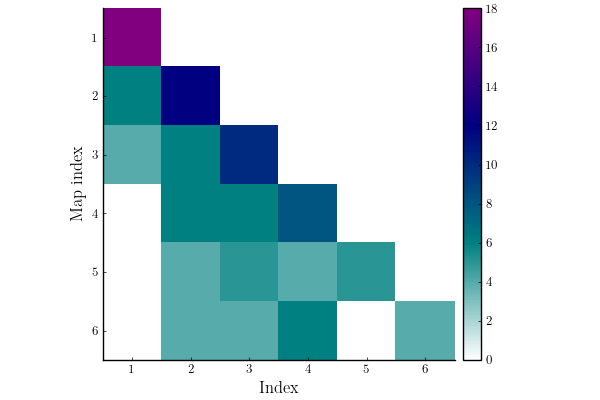

In [43]:
plot(S)

In [33]:
Ωhat = zeros(Ny + Nx, Ny + Nx)
cache = zeros(1, Ny + Nx, Ny + Nx)
for i=1:Ne
    hess_x_log_pdf!(cache, S, X[:,i:i])
    Ωhat .+= copy(cache[1,:,:]).^2
end
rmul!(Ωhat, 1/Ne)

6×6 Array{Float64,2}:
     1.74891e9      5.91025e6  …  1.19012e9      7.01715e5  0.0
     5.91025e6      2.51927e8     1.32943e6      1.33099e8  0.0
 86497.6        47145.5           1.41745e5  51310.4        3.54668e8
     1.19012e9      1.32943e6     1.47005e9      7.31668e5  2.72705e5
     7.01715e5      1.33099e8     7.31668e5      1.57889e8  1.27127e5
     0.0            0.0        …  2.72705e5      1.27127e5  4.26162e8

In [ ]:
?

In [48]:
X

┌ Error: Failed to revise /media/mat/HDD/AdaptiveTransportMap/src/mapcomponent/stochmapfilter.jl
│   exception = Revise.ReviseEvalException("/media/mat/HDD/AdaptiveTransportMap/src/mapcomponent/stochmapfilter.jl:4", ErrorException("invalid redefinition of constant StochMapFilter"), Any[(top-level scope at stochmapfilter.jl:4, 1)])
└ @ Revise /home/mat/.julia/packages/Revise/VxkZO/src/packagedef.jl:707


6×300 Array{Float64,2}:
  2.42777  -0.81218  13.2911   7.32338   …  -12.1905   -8.90286   4.24779
  3.16541   4.39623  19.3326   1.7862       -13.7223  -13.9735    2.5783
 10.576    29.4261   28.4523  31.672         31.8966   17.1862   28.352
  1.62046  -2.60925  12.74     6.64383      -13.2909   -9.28307   3.78465
  2.95506   2.923    17.4034   0.930416     -15.6553  -15.9138    0.680735
  9.83626  28.7171   26.8355  31.4576    …   30.7311   16.2845   26.4838

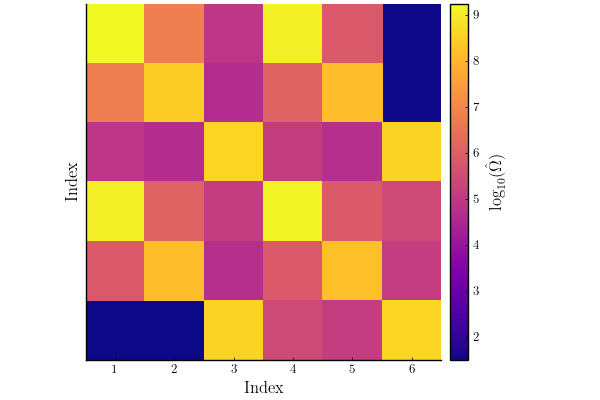

In [36]:
plt = plot()

heatmap!(plt,log10.(Ωhat), ratio = 1, yflip = true, 
        colorbar = true, color = :plasma, clim = (1.5, Inf), colorbar_title = L"\log_{10}(\hat{\Omega})",
        xlabel = "Index", ylabel = "Index", background_color_inside = palette(:plasma)[1], 
        yticks = (reverse(collect(0:10:Nx))))
plt

In [35]:
smf = StochMapFilter(x->x, ϵy, HermiteMap(20, ; diag = true))

LoadError: [91mMethodError: no method matching HermiteMap(::Int64; diag=true)[39m
[91m[0mClosest candidates are:[39m
[91m[0m  HermiteMap(::Int64, [91m::Int64[39m, [91m::LinearTransform[39m, [91m::Array{MapComponent,1}[39m) at /media/mat/HDD/AdaptiveTransportMap/src/mapcomponent/hermitemap.jl:16[91m got unsupported keyword argument "diag"[39m[39m
[91m[0m  HermiteMap(::Int64, [91m::Array{Float64,2}[39m; diag, α) at /media/mat/HDD/AdaptiveTransportMap/src/mapcomponent/hermitemap.jl:33[39m
[91m[0m  HermiteMap(::Any, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m) at /media/mat/HDD/AdaptiveTransportMap/src/mapcomponent/hermitemap.jl:16[91m got unsupported keyword argument "diag"[39m[39m
[91m[0m  ...[39m

In [9]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, m0, C0, 0, 0, 0, F);

For the twin-experiment, we use the function `generate_lorenz63` to integrate forward in time the Lorenz-63 ODE, and generate the observations that will be later assimilated into the ensemble filter. This function can easily be modified for your specific needs.

Set initial condition of the true system

In [10]:
x0 = model.m0 + sqrt(model.C0)*randn(Nx)

3-element Array{Float64,1}:
  0.058188984309341295
 -1.5485755003723605
 -0.6745325333006699

Run dynamics and generate data

In [11]:
data = generate_lorenz63(model, x0, Tf);

In `AdaptiveTransportMap`, we use the following convention to store the state and observation variables. The state and observation variables of the different ensemble members are stored in a matrix `X`. The different columns store the different samples. The first entries of a column contains the observation variables, while the latter contains the state variables. This convention might seems confusing at first, but it is very convenient for conditional density estimation, see notebook 2 or 5 for instance.

In `AdaptiveTransportMap`, the different ensemble filters are of type `SeqFilter`. We have implemented the following filters:
    
* a trivial identity filter
* the stochastic version of the ensemble Kalman filter (sEnKF), Evensen [1].
* a deterministic version of the ensemble Kalman filter: the ensemble transform Kalman filter (ETKF), Bishop et al. [3]. This filter exactly verifies the propagation equation for the covariance matrix of the Kalman filter. This deterministic filter reduced sampling error
* the stochastic map filter (SMF) developed by Spantini et al. [5]. This filter is a nonlinear generalization of the sEnKF based on measure theory. This filter will be presented in the notebooks 6, 7.

New ensemble filter algorithms can easily be integrated with `AdaptiveTransportMap`. The only requirements are: 
To finish this comment

In [156]:
smf = 

Stochastic EnKF  with filtered = false


In [157]:
etkf = ETKF(x->x, model.ϵy, model.Δtdyn, model.Δtobs, 20*model.Δtobs, false, false)

ETKF  with filtered = false


Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [158]:
Ne = 100 #ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
X[model.Ny+1:model.Ny+model.Nx,:] .= sqrt(model.C0)*randn(model.Nx, Ne) .+ model.m0

3×100 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
 -0.152531  -0.43009   -0.84409   …   1.55071    0.00911377  -1.99073
 -0.604179  -1.43155   -1.13024      -0.539315  -1.93767      0.0139871
  0.145089  -0.579626   0.331371     -2.01104   -0.620639    -1.0148

Apply the sequential filter over the time window

The function `seqassim` provides a friendly API to experiment with the different ensemble filters, the tuning of the different inflation parameters...

In [159]:
Xsenkf = seqassim(F, data, Tf, model.ϵx, senkf, deepcopy(X), model.Ny, model.Nx, t0);

In [160]:
Xetkf = seqassim(F, data, Tf, model.ϵx, etkf, deepcopy(X), model.Ny, model.Nx, t0);

In [161]:
mean_hist(Xsenkf[1001:end])

3×4001 Array{Float64,2}:
 -8.00495  -2.11745  -5.01237  -13.4631  …   1.71709   0.987863   3.67144
 -2.81565  -1.59352  -7.58615  -12.2849      2.5711    2.13706    5.88889
 32.5671   21.0196   16.6467    35.1349     15.9897   11.0794    11.0451

In [162]:
data.xt[:,1000:end]

3×4001 Array{Float64,2}:
 -8.59561  -2.62645  -5.63784  -14.1565  …   0.0425693  0.382422  2.81242
 -2.77304  -2.391    -9.30837  -13.9815      0.134579   0.760991  5.74809
 33.343    20.6867   15.5699    34.8562     12.5584     7.44374   5.08979

In [163]:
norm(data.xt[:,2000:end] - mean_hist(Xsenkf[2001:end]))/norm(data.xt[:,2000:end])

0.1331114059032366

In [164]:
norm(data.xt[:,2000:end] - mean_hist(Xetkf[2001:end]))/norm(data.xt[:,2000:end])

0.1731461096719795

In [114]:
# Plot the first component of the state over time
nb = 5800
ne = 6000
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsenkf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "sEnKF")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

LoadError: [91mBoundsError: attempt to access 3000-element Array{Float64,1} at index [5800][39m

In [115]:
# Plot the different component of the state over time
nb = 5500
ne = 6000
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (900, 1000))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  2, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xsenkf)[i,1+nb:Δ:1+ne], linewidth = 2, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt

LoadError: [91mBoundsError: attempt to access 3000-element Array{Float64,1} at index [5500][39m

Talk about the benchmark of the different filters

### Benchmark of the EnKF filter

In [116]:
path = pwd()*"/lorenz63/data/"
Nx = 3
Ny = 3
Ne_array = [10, 20, 40, 60, 100, 200];
@time model, data = setup_lorenz63(path, Ne_array);

Ne 10 RMSE: 3.8254663423276716
Ne 20 RMSE: 2.0605921219961134
Ne 40 RMSE: 0.4223537564608097
Ne 60 RMSE: 0.40146546759545937
Ne 100 RMSE: 0.3877197292448612
Ne 200 RMSE: 0.4025809532902939
 15.443304 seconds (68.89 M allocations: 6.501 GiB, 6.17% gc time)


In [55]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (10, 1.0)
  0.482682 seconds (3.47 M allocations: 329.564 MiB, 11.44% gc time)
Ne = 10
Ne 10& β 1.0 RMSE: 0.6015590736992926


Progress:  17%|██████▉                                  |  ETA: 0:00:05

(Ne, β) = (20, 1.0)
  

Progress:  33%|█████████████▋                           |  ETA: 0:00:04

0.859515 seconds (6.59 M allocations: 631.994 MiB, 8.56% gc time)
Ne = 20
Ne 20& β 1.0 RMSE: 0.5184477645494938
(Ne, β) = (40, 1.0)
  

Progress:  50%|████████████████████▌                    |  ETA: 0:00:04

1.662244 seconds (12.83 M allocations: 1.210 GiB, 8.65% gc time)
Ne = 40
Ne 40& β 1.0 RMSE: 0.4483744816193398
(Ne, β) = (60, 1.0)
  

Progress:  67%|███████████████████████████▍             |  ETA: 0:00:03

2.463622 seconds (19.07 M allocations: 1.804 GiB, 8.51% gc time)
Ne = 60
Ne 60& β 1.0 RMSE: 0.4403101469791623
(Ne, β) = (100, 1.0)
  

Progress:  83%|██████████████████████████████████▏      |  ETA: 0:00:02

4.334649 seconds (31.55 M allocations: 2.983 GiB, 8.49% gc time)
Ne = 100
Ne 100& β 1.0 RMSE: 0.4303647629868742
(Ne, β) = (200, 1.0)
 13.776164 seconds (62.75 M allocations: 5.935 GiB, 7.19% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4465248257137066

Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


6-element Array{Any,1}:
 Metrics[Metrics(10, [0.8166106052280312, 0.8477976249831615, 0.5377435004826744, 0.2946057216215732, 0.1963372890873663, 0.1661211989653268, 0.09550122139602638, 0.10895691501209233, 0.061645037116889324, 0.1556247918798692  …  4.0942175082812975, 2.918216773645667, 2.293946056603929, 2.3368525142834664, 2.9966610036699945, 2.488711153121422, 2.060789991067101, 2.000268585410395, 2.0094430111553767, 1.633586039615903], 0.37686107778341077, 0.6015590736992926, 0.8149386709205617, [1.0125271950095414, 0.9623361052178709, 0.7792957424814254, 0.4344193482216172, 0.2873587820499424, 0.2729751953413108, 0.40382950988831384, 0.6108278943470481, 0.6592219807793599, 0.4157011617649463  …  0.6622613427311322, 0.9156031963385003, 1.1880540752197546, 1.010250360884169, 0.9055102239545725, 0.6429162631150634, 0.5592022167774022, 0.6557579770729094, 0.987851621549649, 1.1234614213819019], 0.4419068954362283, 0.5053138269227165, 0.25903240927442023, [1.0, 1.0, 0.6666666666666

In [23]:
metric_list = benchmark_lorenz63(model, data, path, Ne_array, [1.0])

(Ne, β) = (200, 1.0)
  7.739944 seconds (62.75 M allocations: 5.935 GiB, 6.06% gc time)
Ne = 200
Ne 200& β 1.0 RMSE: 0.4189442707516625


1-element Array{Any,1}:
 Metrics[Metrics(200, [0.27418871478089074, 0.4011111920900346, 0.6224367042654201, 1.1940241372680338, 1.178706937442249, 0.629896584355798, 0.37352902606306937, 0.27598562967074297, 0.3415108073527272, 0.5385900049790774  …  0.22005926456584765, 0.11117371050261328, 0.0745833426310767, 0.06915409494524392, 0.23566185689849842, 0.4284533696688461, 0.7382482677445492, 1.2785156926466672, 0.9477650979445261, 0.8579855755647071], 0.2843509443072877, 0.4189442707516625, 0.3843942458358231, [0.2791191166770778, 0.3308824803118106, 0.5356751453956368, 0.7482658949655999, 0.6849666981780923, 0.5401293761758875, 0.3905840265207302, 0.30529026491290673, 0.3612676308031941, 0.5506587576884893  …  0.9550452598208562, 0.7275900415277436, 0.5097020874896808, 0.38068472189933705, 0.44668108906035564, 0.6711198461183089, 0.7934070557338772, 0.953289237580203, 1.0821830718436276, 1.1373384160933897], 0.529889526630428, 0.584733698922179, 0.23401428353181045, [1.0, 1.0, 1.0, 1.